#  Solar Activity vs Global Temperature
### **Analysis Notebook**

This notebook explores the relationship between **solar activity** (Sunspots, TSI) and **global temperature anomalies** using cleaned datasets.


## Load Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')
sunspots_clean = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/Final Projects Statistics Fall 2025/Sunspots.xlsx")
tsi_clean = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/Final Projects Statistics Fall 2025/TSI.xlsx")
temps_clean = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/Final Projects Statistics Fall 2025/Temperatures.xlsx")

Mounted at /content/drive


## Compute Yearly Means

In [3]:
temps_clean.columns


Index(['Year', 'January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August', 'September', 'October', 'November', 'December', 'J-D', 'D-N',
       'DJF', 'MAM', 'JJA', 'SON'],
      dtype='object')

In [4]:

months = ["January","February","March","April","May","June",
          "July","August","September","October","November","December"]

# Ensure ALL monthly columns are numeric (fixes strings, spaces, dashes, etc.)
for col in months:
    sunspots_clean[col] = pd.to_numeric(sunspots_clean[col], errors='coerce')
    tsi_clean[col] = pd.to_numeric(tsi_clean[col], errors='coerce')
    temps_clean[col] = pd.to_numeric(temps_clean[col], errors='coerce')

# Now safely compute yearly means
sunspots_clean['Sunspots'] = sunspots_clean[months].mean(axis=1)
tsi_clean['TSI'] = tsi_clean[months].mean(axis=1)
temps_clean['Temperature'] = temps_clean[months].mean(axis=1)

##  Merge Final Dataset

In [5]:
merged = (
    sunspots_clean[['Year','Sunspots']]
    .merge(tsi_clean[['Year','TSI']], on='Year')
    .merge(temps_clean[['Year','Temperature']], on='Year')
)
merged.head()

,Year,Sunspots,TSI,Temperature
0,1881,90.508333,1361.748400,-0.088333
1,1882,99.375000,1361.717833,-0.113333
2,1883,106.058333,1361.671742,-0.173333
3,1884,105.841667,1361.736517,-0.283333
4,1885,86.633333,1361.636950,-0.335833


##  Exploratory Data Analysis (EDA)
### 5.1 Time Series Plots

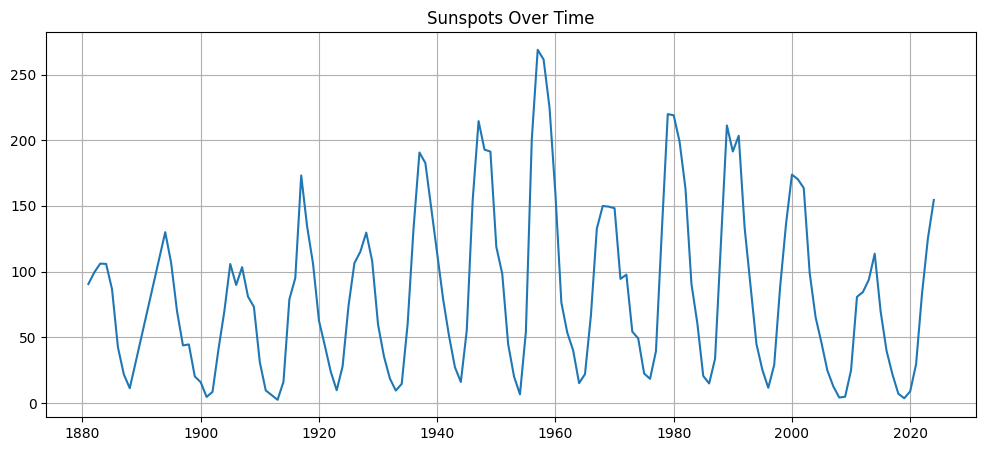

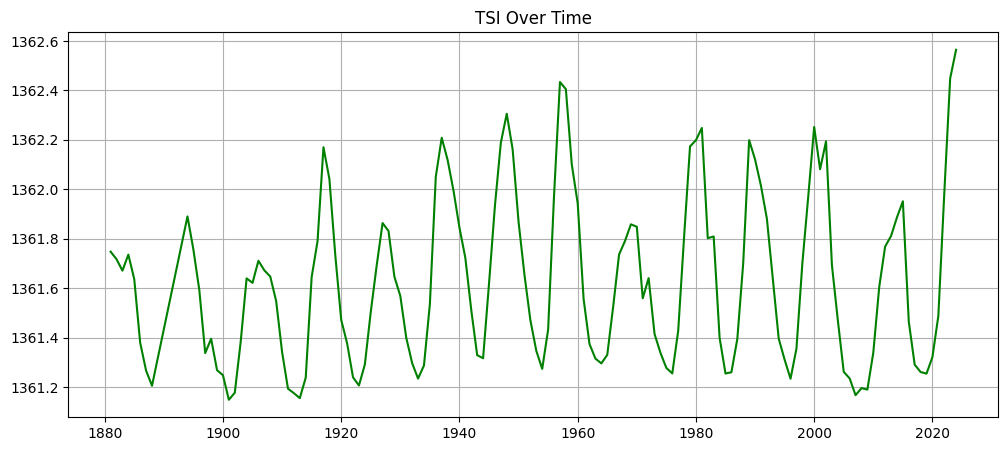

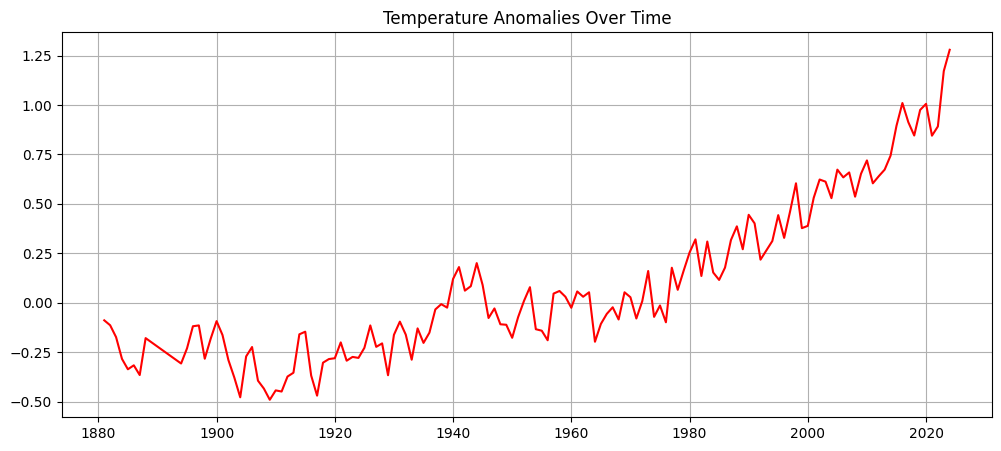

In [6]:
plt.figure(figsize=(12,5))
plt.plot(merged['Year'], merged['Sunspots'], label='Sunspots')
plt.title('Sunspots Over Time')
plt.grid(True)
plt.show()

plt.figure(figsize=(12,5))
plt.plot(merged['Year'], merged['TSI'], label='TSI', color='green')
plt.title('TSI Over Time')
plt.grid(True)
plt.show()

plt.figure(figsize=(12,5))
plt.plot(merged['Year'], merged['Temperature'], label='Temp Anomaly', color='red')
plt.title('Temperature Anomalies Over Time')
plt.grid(True)
plt.show()

###  5.2 Combined Scaled Time Series

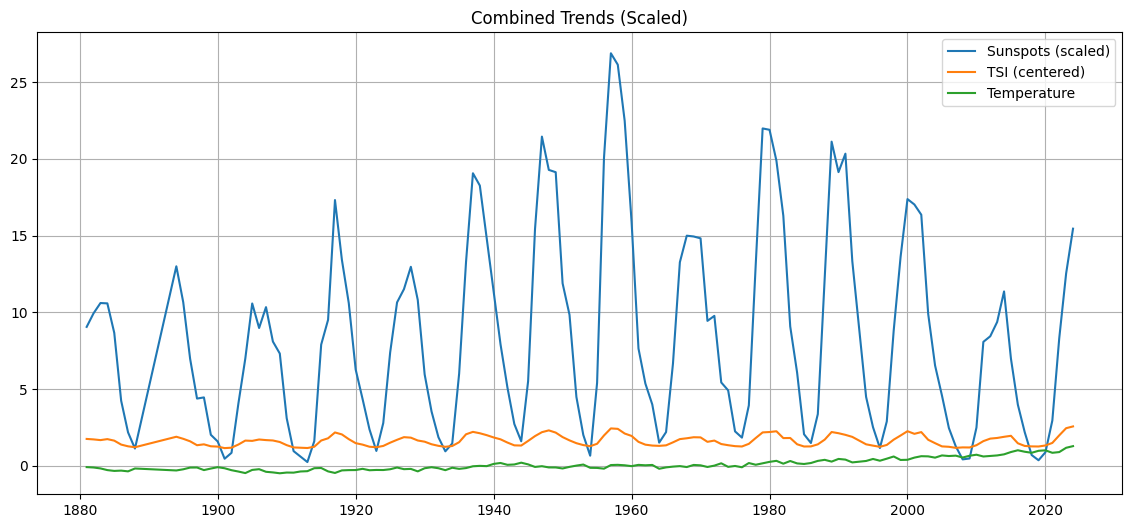

In [7]:
plt.figure(figsize=(14,6))
plt.plot(merged['Year'], merged['Sunspots']/10, label='Sunspots (scaled)')
plt.plot(merged['Year'], merged['TSI']-1360, label='TSI (centered)')
plt.plot(merged['Year'], merged['Temperature'], label='Temperature')
plt.legend()
plt.title('Combined Trends (Scaled)')
plt.grid(True)
plt.show()

###  5.3 Correlation Heatmap

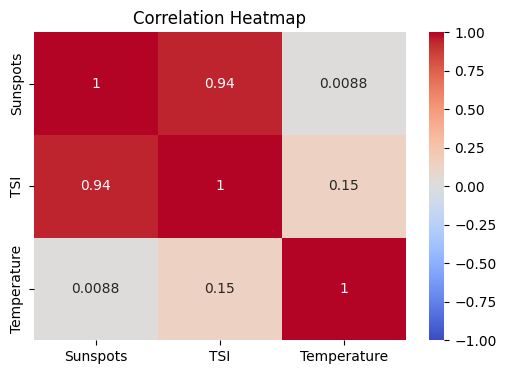

In [8]:
corr = merged[['Sunspots','TSI','Temperature']].corr()
plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

### 5.4 Scatterplots with Trendlines

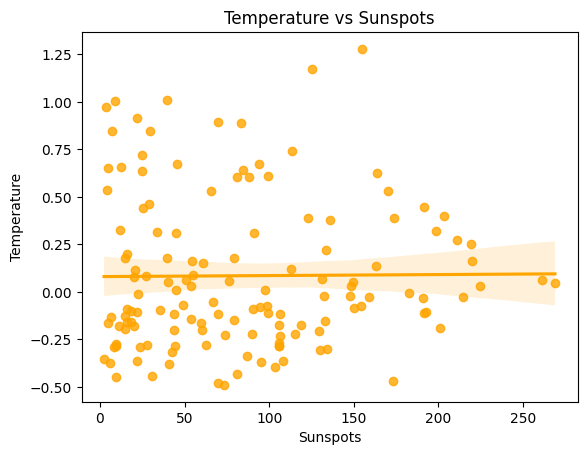

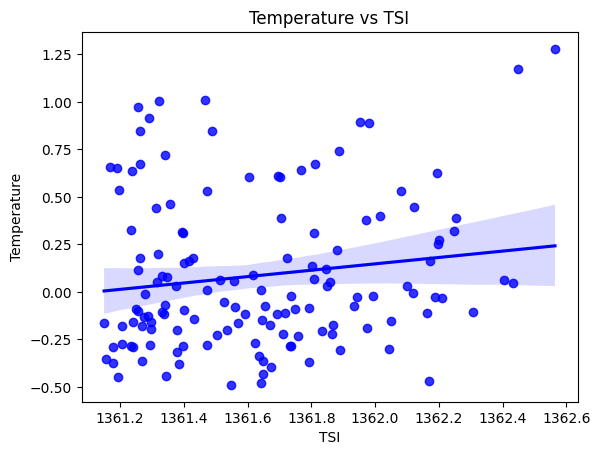

In [9]:
sns.regplot(x='Sunspots', y='Temperature', data=merged, color='orange')
plt.title('Temperature vs Sunspots')
plt.show()

sns.regplot(x='TSI', y='Temperature', data=merged, color='blue')
plt.title('Temperature vs TSI')
plt.show()

##  Advanced Analysis
### 6.1 Lag Correlation (Solar effect delay)

In [10]:
merged['Sunspots_lag1'] = merged['Sunspots'].shift(1)
merged['TSI_lag1'] = merged['TSI'].shift(1)
merged[['Sunspots_lag1','TSI_lag1','Temperature']].corr()

,Sunspots_lag1,TSI_lag1,Temperature
Sunspots_lag1,1.000000,0.945997,0.003650
TSI_lag1,0.945997,1.000000,0.115171
Temperature,0.003650,0.115171,1.000000


### 📉 6.2 Regression Analysis

In [11]:
import statsmodels.api as sm

X = merged[['Sunspots','TSI']]
X = sm.add_constant(X)
y = merged['Temperature']

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Temperature   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     12.66
Date:                Sun, 16 Nov 2025   Prob (F-statistic):           9.13e-06
Time:                        01:06:49   Log-Likelihood:                -55.284
No. Observations:                 138   AIC:                             116.6
Df Residuals:                     135   BIC:                             125.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1785.9552    355.022     -5.031      0.000   -2488.078   -1083.832
Sunspots      -0.0065      0.001     -4.678      0.000      -0.009      -0.004
TSI            1.3121      0.261      5.031      0.000       0.796       1.828
==============================================================================
Omnibus:                        7.371   Durbin-Watson:                   0.207
Prob(Omnibus):                  0.025   Jarque-Bera (JB):                7.433
Skew:                           0.531   Prob(JB):                       0.0243
Kurtosis:                       2.592   Cond. No.                     1.56e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.56e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Monthly Analysis
Add monthly correlation, plots, and descriptive stats here.

In [12]:
# Example: Monthly mean temperature, sunspots, TSI
monthly_means = merged.groupby(merged['Year']).mean()
monthly_means.head()

,Sunspots,TSI,Temperature,Sunspots_lag1,TSI_lag1
Year,,,,,
1881,90.508333,1361.748400,-0.088333,NaN,NaN
1882,99.375000,1361.717833,-0.113333,90.508333,1361.748400
1883,106.058333,1361.671742,-0.173333,99.375000,1361.717833
1884,105.841667,1361.736517,-0.283333,106.058333,1361.671742
1885,86.633333,1361.636950,-0.335833,105.841667,1361.736517


## Seasonal Analysis
Add seasonal grouping (DJF, MAM, JJA, SON).

In [13]:
import numpy as np

# Assign seasons
def assign_season(month):
    return ('Winter' if month in [12,1,2] else
            'Spring' if month in [3,4,5] else
            'Summer' if month in [6,7,8] else
            'Autumn')

# Example seasonal aggregation (requires melted data)


## Interval Analysis
Add decade or interval-based trends.

In [14]:
merged['Decade'] = (merged['Year']//10)*10
decadal_avg = merged.groupby('Decade')[['Sunspots','TSI','Temperature']].mean()
decadal_avg

,Sunspots,TSI,Temperature
Decade,,,
1880,70.476042,1361.545698,-0.231667
1890,69.138889,1361.540993,-0.205556
1900,59.243333,1361.480484,-0.321000
1910,65.258333,1361.549360,-0.334500
1920,70.073333,1361.513118,-0.245917
1930,85.155000,1361.670253,-0.125167
1940,109.437500,1361.793691,0.041417
1950,129.851667,1361.796533,-0.048583
1960,86.453333,1361.573395,-0.029583


## Monthly Plots and Tables

In [15]:
# Monthly averages for each variable
monthly_table = temps_clean[months].mean().to_frame(name='Avg_Temperature')
monthly_table


,Avg_Temperature
January,0.076164
February,0.084178
March,0.102603
April,0.075342
May,0.063356
June,0.051027
July,0.075205
August,0.075068
September,0.080890
October,0.105822


<Figure size 1000x500 with 0 Axes>

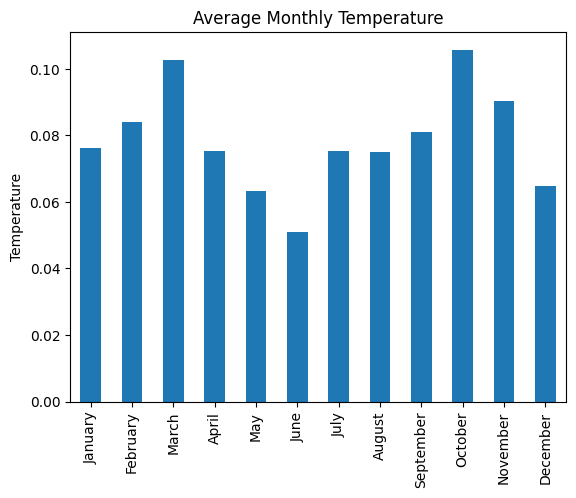

In [16]:
plt.figure(figsize=(10,5))
monthly_table.plot(kind='bar',legend=False,title='Average Monthly Temperature')
plt.ylabel('Temperature')
plt.show()

## Seasonal Plots and Tables

In [17]:
# Build melted version for seasons
temps_melt = temps_clean.melt(id_vars='Year',value_vars=months,var_name='Month',value_name='Temp')
month_to_num={m:i+1 for i,m in enumerate(months)}
temps_melt['MonthNum']=temps_melt['Month'].map(month_to_num)
def season(m): return ('Winter' if m in [12,1,2] else 'Spring' if m in [3,4,5] else 'Summer' if m in [6,7,8] else 'Autumn')
temps_melt['Season']=temps_melt['MonthNum'].apply(season)
season_avg=temps_melt.groupby('Season')['Temp'].mean().to_frame()
season_avg

,Temp
Season,
Autumn,0.092311
Spring,0.080434
Summer,0.067100
Winter,0.075080


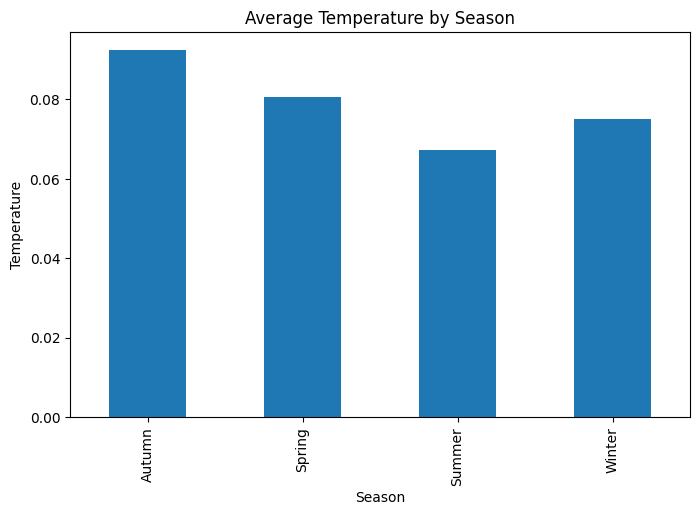

In [18]:
season_avg.plot(kind='bar',title='Average Temperature by Season',legend=False,figsize=(8,5))
plt.ylabel('Temperature')
plt.show()

## Interval (Decadal) Plots and Tables

In [19]:
interval_table = merged.groupby('Decade')[['Sunspots','TSI','Temperature']].mean()
interval_table

,Sunspots,TSI,Temperature
Decade,,,
1880,70.476042,1361.545698,-0.231667
1890,69.138889,1361.540993,-0.205556
1900,59.243333,1361.480484,-0.321000
1910,65.258333,1361.549360,-0.334500
1920,70.073333,1361.513118,-0.245917
1930,85.155000,1361.670253,-0.125167
1940,109.437500,1361.793691,0.041417
1950,129.851667,1361.796533,-0.048583
1960,86.453333,1361.573395,-0.029583


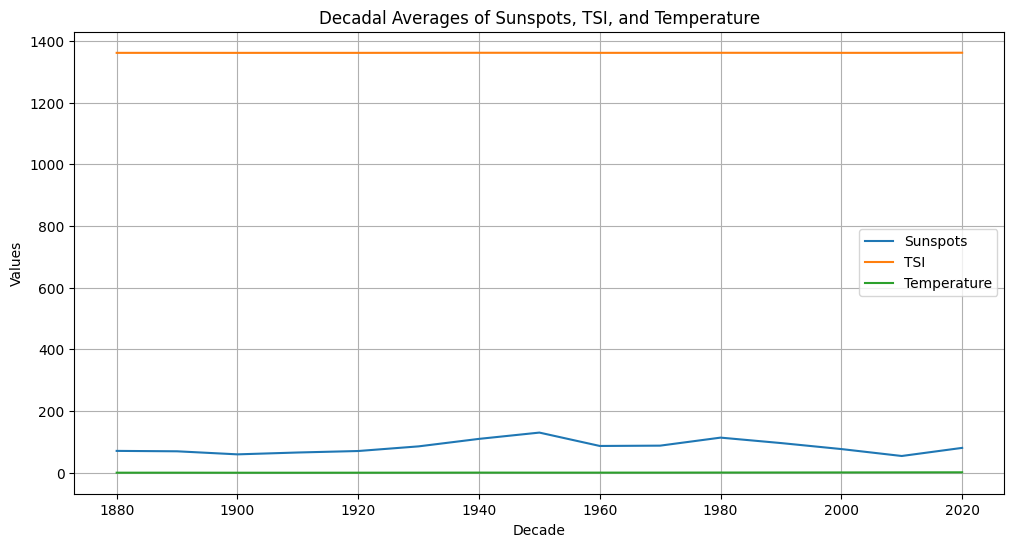

In [20]:
interval_table.plot(figsize=(12,6),title='Decadal Averages of Sunspots, TSI, and Temperature')
plt.ylabel('Values')
plt.grid(True)
plt.show()